# Problem Set 7
## [Ruolin Fang]

In [20]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.interpolate import LSQUnivariateSpline
import warnings
warnings.filterwarnings('ignore')

### Question 1
#### 1.a

In [121]:
wine = pd.read_csv('data/strongdrink.txt')

In [122]:
X = wine[['alco', 'malic', 'tot_phen', 'color_int']]
y = wine['cultivar']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 20)
logit = LogisticRegression(random_state = 20, solver = 'lbfgs', 
                           multi_class = 'multinomial').fit(X_train, y_train)

In [123]:
j1 = [logit.intercept_[0]] + logit.coef_[0].tolist()
j2 = [logit.intercept_[1]] + logit.coef_[1].tolist()
results = pd.DataFrame(data = {'j = 1':j1, 'j = 2':j2}, 
                       index = ['intercept', 'b1', 'b2', 'b3', 'b4'])
results

,j = 1,j = 2
intercept,-24.027619,22.780735
b1,1.701735,-1.466297
b2,-0.265788,-0.332952
b3,1.224101,0.663556
b4,0.022507,-0.922682


In [124]:
y_pred = logit.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          1       0.87      1.00      0.93        13
          2       1.00      0.90      0.95        21
          3       1.00      1.00      1.00        10

avg / total       0.96      0.95      0.96        44



In [125]:
wine['cultivar'].value_counts()

2    71
1    59
3    46
Name: cultivar, dtype: int64

The error rates for category 1, 2, and 3 are 0.13, 0.0, and 0.0 respectively.
The model is best at predicting the 3rd category, but the category with the most observations is the 2nd one.

In [127]:
MSE_vs = ((y_test - y_pred) ** 2).sum() / y_pred.shape[0]
print('Validation set MSE = ', MSE_vs)

Validation set MSE =  0.045454545454545456


#### 1.b

In [128]:
Xvars = X.values
yvars = y.values
N_loo = Xvars.shape[0]
loo = LeaveOneOut()
loo.get_n_splits(Xvars)
MSE_vec = np.zeros(N_loo)
yt = np.zeros(N_loo)
yp = np.zeros(N_loo)

for train_index, test_index in loo.split(Xvars):
    X_train, X_test = Xvars[train_index], Xvars[test_index]
    y_train, y_test = yvars[train_index], yvars[test_index]
    LogReg = LogisticRegression(random_state = 20, solver = 'lbfgs', 
                                multi_class = 'multinomial')
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    yt[test_index] = y_test
    yp[test_index] = y_pred
    if y_test == y_pred:
        MSE_vec[test_index] = 0
    else:
        MSE_vec[test_index] = 1

MSE_loo = MSE_vec.mean()
MSE_loo_std = MSE_vec.std()
print('Test estimate MSE LOOCV =', MSE_loo,
      '\nTest estimate MSE standard error =', MSE_loo_std)

Test estimate MSE LOOCV = 0.07954545454545454 
Test estimate MSE standard error = 0.2705882022679695


In [129]:
print(classification_report(yt, yp))

             precision    recall  f1-score   support

        1.0       0.90      0.93      0.92        59
        2.0       0.91      0.90      0.91        71
        3.0       0.96      0.93      0.95        46

avg / total       0.92      0.92      0.92       176



The error rate for the 1st category decreases from 0.13 to 0.1, while that for the 2nd and 3rd category increases to 0.09 and 0.04 respectively.

#### 1.c

In [130]:
k = 4
kf = KFold(n_splits = k, random_state = 20, shuffle = True)
kf.get_n_splits(Xvars)

MSE_vec_kf = np.zeros(k)
yt = np.zeros(N_loo)
yp = np.zeros(N_loo)
k_ind = int(0)

for train_index, test_index in kf.split(Xvars):
    X_train, X_test = Xvars[train_index], Xvars[test_index]
    y_train, y_test = yvars[train_index], yvars[test_index]
    LogReg = LogisticRegression(random_state = 20, solver = 'lbfgs', 
                                multi_class = 'multinomial')
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    yt[test_index] = y_test
    yp[test_index] = y_pred
    
    mse = []
    for i in range(len(y_test)):
        if y_test[i] == y_pred[i]:
            mse.append(0)
        else:
            mse.append(1)
    MSE_vec_kf[k_ind] = np.array(mse).mean()
    k_ind += 1

In [131]:
MSE_vec_kf = np.array(MSE_vec_kf)
MSE_kf = MSE_vec_kf.mean()
MSE_kf_std = MSE_vec_kf.std()
print('Test estimate MSE k-fold =', MSE_kf,
      '\nTest estimate MSE standard error =', MSE_kf_std)

Test estimate MSE k-fold = 0.08522727272727273 
Test estimate MSE standard error = 0.02476647127011746


In [132]:
print(classification_report(yt, yp))

             precision    recall  f1-score   support

        1.0       0.90      0.92      0.91        59
        2.0       0.90      0.90      0.90        71
        3.0       0.96      0.93      0.95        46

avg / total       0.92      0.91      0.91       176



The error rate for the 1st category is 0.1 - the same as part (b) and lower than part(a), for the 2nd category has increased to 0.1, and for the 3rd category is the same as part (b) (0.4), but is higher than part (a).

### Question 2
#### 2.a

In [6]:
cool = pd.read_csv('data/CoolIndex.txt', names = ['age', 'coolness'])

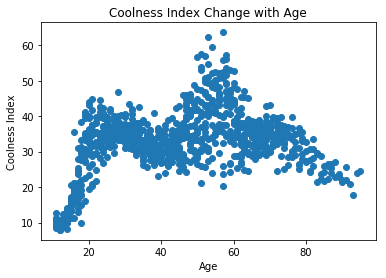

In [8]:
plt.scatter(cool['age'], cool['coolness'])
plt.xlabel('Age')
plt.ylabel('Coolness Index')
plt.title('Coolness Index Change with Age')
plt.show()

#### 2.b

In [12]:
cool['bin1'] = np.where((cool['age'] >= 11) & (cool['age'] < 22), 1, 0)
cool['bin2'] = np.where((cool['age'] >= 22) & (cool['age'] < 40), 1, 0)
cool['bin3'] = np.where((cool['age'] >= 40) & (cool['age'] < 59), 1, 0)
cool['bin4'] = np.where((cool['age'] >= 59) & (cool['age'] < 77), 1, 0)
cool['bin5'] = np.where((cool['age'] >= 77) & (cool['age'] <= 95), 1, 0)

In [13]:
x = cool[['bin1', 'bin2', 'bin3', 'bin4', 'bin5']]
y = cool['coolness']
reg = sm.OLS(y, x).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:               coolness   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     178.7
Date:                Tue, 26 Feb 2019   Prob (F-statistic):          3.73e-114
Time:                        20:10:13   Log-Likelihood:                -3214.5
No. Observations:                 956   AIC:                             6439.
Df Residuals:                     951   BIC:                             6463.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
bin1          20.1025      0.562     35.746      0.0

The estimated coefficients are: beta1 = 20.10, beta2 = 34.48, beta3 = 37.64, beta4 = 35.23, beta5 = 27.30

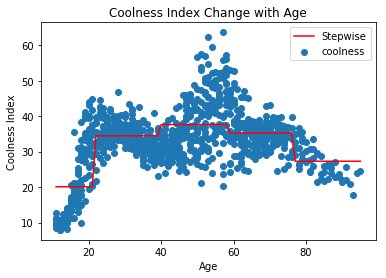

In [16]:
plt.scatter(cool['age'], cool['coolness'])
plt.plot(cool['age'], reg.predict(), color = 'r', label = 'Stepwise')
plt.legend()
plt.xlabel('Age')
plt.ylabel('Coolness Index')
plt.title('Coolness Index Change with Age')
plt.show()

In [17]:
reg.predict([0, 0, 0, 1, 0])

array([35.22540004])

The predicted coolness of a 73-year old from the stepwise function is 35.2.

#### 2.c

In [21]:
c2 = cool.groupby('age').mean()
c2 = c2.reset_index()
lin_spline = LSQUnivariateSpline(np.array(c2['age']), np.array(c2['coolness']),
                   t = [22, 40, 59, 77], k = 1)

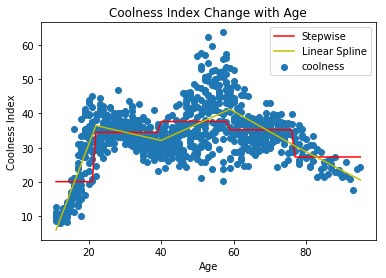

In [28]:
plt.scatter(cool['age'], cool['coolness'])
plt.plot(cool['age'], reg.predict(), color = 'r', label = 'Stepwise')
plt.plot(c2['age'], lin_spline(c2['age']), color = 'y', label = 'Linear Spline')
plt.legend()
plt.xlabel('Age')
plt.ylabel('Coolness Index')
plt.title('Coolness Index Change with Age')
plt.show()

In [25]:
lin_spline(73)

array(32.86784862)

The predicted coolness of a 73-year old from the linear spline is 32.9

#### 2.d

In [26]:
cubic_spline = LSQUnivariateSpline(np.array(c2['age']), np.array(c2['coolness']),
                   t = [22, 40, 59, 77], k = 3)

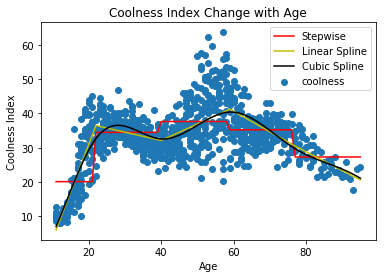

In [29]:
plt.scatter(cool['age'], cool['coolness'])
plt.plot(cool['age'], reg.predict(), color = 'r', label = 'Stepwise')
plt.plot(c2['age'], lin_spline(c2['age']), color = 'y', label = 'Linear Spline')
plt.plot(c2['age'], cubic_spline(c2['age']), color = 'k', label = 'Cubic Spline')
plt.legend()
plt.xlabel('Age')
plt.ylabel('Coolness Index')
plt.title('Coolness Index Change with Age')
plt.show()

In [30]:
cubic_spline(73)

array(32.64230107)

The predicted coolness of a 73-year old from the cubic spline is 32.6.